In [2]:
import os
from os.path import join
import pandas as pd
import numpy as np
import sklearn as sk
from matplotlib import pyplot as plt

%matplotlib inline
%precision 3

'%.3f'

In [9]:
class G:
    base_dir = os.path.abspath(join(".."))
    data_dir = os.path.abspath(join("..", "data"))

In [14]:
import numpy as np
import pandas as pd
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt 
# from sklearn.metrics import f1_score, precision_score, recall_score

def classifier_evaluator( model, x, y ):
    """ generate evaluation report on binary classifier
    """
    y_true = y
    # calculate auc
    probas_ = model.predict_proba( x )[:, 1]
    fpr, tpr, thresholds = roc_curve( y_true, probas_ )
    roc_auc = auc( fpr, tpr )
    # calcualte F1-score, recall, precision
    y_pred = model.predict( x )
    # the number of true positive
    num_tp = sum([ 1 for pred, obs in zip(y_pred, y) if pred == obs and obs == 1 ])
    sensitivity = num_tp / sum(y_true == 1)
    return roc_auc, sensitivity
    
def model_selection_cv( models, x, y, k=5, random_state=123, eval_func=None ):
    """ framework for model selection based on stratified 
        cross-validation
    
        Parameters:
        ----------
        * models: {dictionary}, key: model label, value: learner object
        * x: {np.array}, predictor data 
        * y: {np.array}, response variable data
        * k: {integer}, the number of folds in cross-validation
        * random_state: {integer}, the random state set for replication
        * eval_func: {function}, return evaulation score
    """
    # stratified cross_validation
    cv = StratifiedKFold( y, n_folds=k, shuffle=False, random_state=random_state)
    tot_models = len( models.keys() )
    tot_iterations = tot_models * k 
    
    # results container
    eval_report = []
    for jj, model_name in enumerate(models):
        model = models[model_name]
        # cross-validation evaluation containers
        train_scores = []
        test_scores = []
        print( "--- model: {}'s cross-validation test ----".format( model_name ) )
        for ii, (train_idx, test_idx) in enumerate(cv):
            # retrieve data for relevant usage
            x_train, y_train = x[train_idx], y[train_idx]
            x_test, y_test = x[test_idx], y[test_idx]
            # training model 
            model.fit( x_train, y_train )
            # evaluation model 
            train_scores.append( eval_func( model, x_train, y_train ) )
            test_scores.append( eval_func( model, x_test, y_test ) )
       
        train_scores = np.array( train_scores )
        test_scores = np.array( test_scores )
        # summarize performance 
        # train scores
        train_auc_mean, train_sensitivity_mean = train_scores.mean(axis=0)
        train_auc_std, train_sensitivity_std = train_scores.std(axis=0)
        # test scores
        test_auc_mean, test_sensitivity_mean = test_scores.mean(axis=0)
        test_auc_std, test_sensitivity_std = test_scores.std(axis=0)
        
        eval_info = [model_name, \
                     train_auc_mean, train_auc_std, \
                     train_sensitivity_mean, train_sensitivity_std, \
                     test_auc_mean, test_auc_std, \
                     test_sensitivity_mean, test_sensitivity_std]
    
        eval_report.append( eval_info )
     
    col_names = ['model_name', \
                 'train_auc_mean', 'train_auc_std', \
                 'train_sensitivity_mean', 'train_sensitivity_std', \
                 'test_auc_mean', 'test_auc_std', \
                 'test_sensitivity_mean', 'test_sensitivity_std'\
                 ] 
    eval_report = pd.DataFrame( eval_report, columns = col_names )
    return eval_report 
    
    
def eval_barchart( df, 
                  test_metrics_colnames, 
                  train_metrics_colnames,
                  label_colname = None, 
                  ylabel = 'Performance Score' ):
    """ plot model evaluation performance 
    
        Parameters:
        ----------
        * df: {pandas.DataFrame}
        * label_colname: {string}, the column name for colum keeping model name 
        * test_metrics_colnames: {list}, columns for test metric mean, columns for test metric std.
        * train_metrics_colnames: {list}, columns for train metric mean, columns for train metric std.
        * ylabel: {string} y-axis label 
    """    
    if ( label_colname==None ):
        label_colname = df.columns[0]
    
    labels = df[ label_colname ].tolist()
    
    test_mean = df[ test_metrics_colnames[0] ].tolist()
    test_std  = df[ test_metrics_colnames[1] ].tolist()
    
    train_mean = df[ train_metrics_colnames[0] ].tolist()
    train_std  = df[ train_metrics_colnames[1] ].tolist()
    
    # graphic parameter
    N = len(labels)
    ind = np.arange(N)
    width = 0.35 # the width of the bars
    
    fig, ax = plt.subplots()
    # plot 1st test error
    rects1 = ax.bar(ind, test_mean, width, color='g', yerr = test_std)
    # plot 2nd train error
    rects2 = ax.bar(ind + width, train_mean, width, color='b', yerr = train_std)

    # add some text for labels, title and axes ticks
    ax.set_ylim( 0, 1 )
    ax.set_ylabel( ylabel )
    ax.set_title( 'Evaluation Results Bar-Chart' )
    ax.set_xticks( ind + width )
    ax.set_xticklabels( labels, rotation=20 )
    ax.legend( ( rects1[0], rects2[0] ), ('Test', 'Train') )

    def autolabel(rects):
        # attach some text labels
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() / 2., 
                    1.05*height,
                    '%d' % int(height),
                     ha='center', va='bottom')
    
    autolabel( rects1 )
    autolabel( rects2 )
    
    return fig 

### load data

In [23]:
train_df = pd.read_csv(join(G.data_dir, "train_data.csv"), header=0, sep=",")

In [22]:
features = {"predictors": ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7'],
            "target": "is_developer"}

xx_data = train_df[features["predictors"]].as_matrix()
yy_data = train_df[features["target"]].as_matrix()
print("positive percentage: {}".format(sum(yy_data) / len(yy_data)))

positive percentage: 0.134


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

LogisticModel = LogisticRegression(penalty='l1', C=0.1, max_iter=1000)
Boosting = AdaBoostClassifier()
RF = RandomForestClassifier()
SVM = SVC( probability=True)

classifiers = {"Logistic Regression (L1: Lasso)": LogisticModel, 
               "SVM (Kernel=RDF)": SVM,
               "Boosting Tree": Boosting, 
               "Random Forest": RF}

In [26]:
_RANDOM_STATE = 123
model_slc_report = model_selection_cv(classifiers, xx_data, yy_data,
                                      k=10, random_state=_RANDOM_STATE, 
                                      eval_func = classifier_evaluator )

--- model: SVM (Kernel=RDF)'s cross-validation test ----
--- model: Boosting Tree's cross-validation test ----
--- model: Logistic Regression (L1: Lasso)'s cross-validation test ----
--- model: Random Forest's cross-validation test ----


In [27]:
model_slc_report

,model_name,train_auc_mean,train_auc_std,train_sensitivity_mean,train_sensitivity_std,test_auc_mean,test_auc_std,test_sensitivity_mean,test_sensitivity_std
0,SVM (Kernel=RDF),0.937348,0.002059,0.014077,0.008300,0.926648,0.020622,0.007692,0.023077
1,Boosting Tree,1.000000,0.000000,1.000000,0.000000,0.998116,0.004370,0.978022,0.033602
2,Logistic Regression (L1: Lasso),0.793961,0.013583,0.000000,0.000000,0.753598,0.067493,0.000000,0.000000
3,Random Forest,0.999924,0.000098,0.957686,0.014668,0.945675,0.027697,0.296703,0.093018


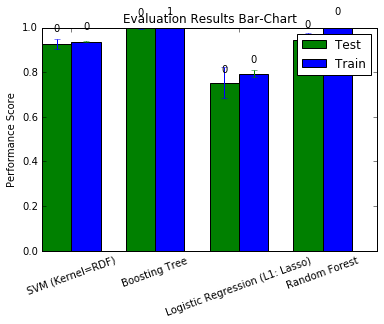

In [28]:
auc_barchart = eval_barchart( model_slc_report, 
                              test_metrics_colnames = ['test_auc_mean', 'test_auc_std'], 
                              train_metrics_colnames = ['train_auc_mean', 'train_auc_std'], 
                              label_colname = 'model_name' )

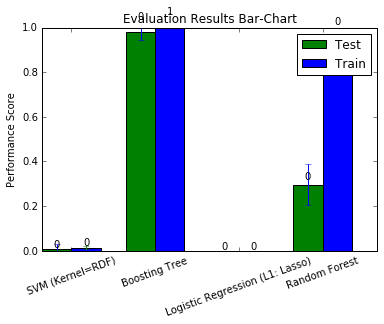

In [29]:
sensitivity_barchart = eval_barchart(model_slc_report, 
                              test_metrics_colnames = ['test_sensitivity_mean', 'test_sensitivity_std'], 
                              train_metrics_colnames = ['train_sensitivity_mean', 'train_sensitivity_std'], 
                              label_colname = 'model_name' )